<center><h1> Predict heart failure with Watson Machine Learning</h1></center>
![alt text](https://www.cdc.gov/dhdsp/images/heart_failure.jpg "Heart failure")
<p>This notebook contains steps and code to create a predictive model to predict heart failure and then deploy that model to Watson Machine Learning so it can be used in an application.</p>
## Learning Goals
The learning goals of this notebook are:
* Load a CSV file into the  Object Storage Service linked to your Data Science Experience 
* Create an Apache® Spark machine learning model
* Train and evaluate a model
* Persist a model in a Watson Machine Learning repository

## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
* Create a Watson Machine Learning Service instance (a free plan is offered) and associate it with your project
* Upload heart failure  data to the Object Store service that is part of your data Science Experience trial


In [3]:
!pip install ibmos2spark

## 2. Load and explore data
<p>In this section you will load the data as an Apache® Spark DataFrame and perform a basic exploration.</p>

<p>Load the data to the Spark DataFrame from your associated Object Storage instance.</p>

In [2]:
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'get your endpoint',
    'api_key': 'get your api key',
    'service_id': 'get your service id',
    'iam_service_endpoint': 'get your iam_service_endpoint'}

configuration_name = 'get your configuration_name'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(cos.url('patientdataV6.csv', 'heartmodel-donotdelete-pr-aiitgp2ifpc0i2'))
df_data.take(5)


[Row(AVGHEARTBEATSPERMIN=93, PALPITATIONSPERDAY=22, CHOLESTEROL=163, BMI=25, HEARTFAILURE='N', AGE=49, SEX='F', FAMILYHISTORY='N', SMOKERLAST5YRS='N', EXERCISEMINPERWEEK=110),
 Row(AVGHEARTBEATSPERMIN=108, PALPITATIONSPERDAY=22, CHOLESTEROL=181, BMI=24, HEARTFAILURE='N', AGE=32, SEX='F', FAMILYHISTORY='N', SMOKERLAST5YRS='N', EXERCISEMINPERWEEK=192),
 Row(AVGHEARTBEATSPERMIN=86, PALPITATIONSPERDAY=0, CHOLESTEROL=239, BMI=20, HEARTFAILURE='N', AGE=60, SEX='F', FAMILYHISTORY='N', SMOKERLAST5YRS='N', EXERCISEMINPERWEEK=121),
 Row(AVGHEARTBEATSPERMIN=80, PALPITATIONSPERDAY=36, CHOLESTEROL=164, BMI=31, HEARTFAILURE='Y', AGE=45, SEX='F', FAMILYHISTORY='Y', SMOKERLAST5YRS='N', EXERCISEMINPERWEEK=141),
 Row(AVGHEARTBEATSPERMIN=66, PALPITATIONSPERDAY=36, CHOLESTEROL=185, BMI=23, HEARTFAILURE='N', AGE=39, SEX='F', FAMILYHISTORY='N', SMOKERLAST5YRS='N', EXERCISEMINPERWEEK=63)]

Explore the loaded data by using the following Apache® Spark DataFrame methods:
* print schema
* print top ten records
* count all records

In [3]:
df_data.printSchema()

root
 |-- AVGHEARTBEATSPERMIN: integer (nullable = true)
 |-- PALPITATIONSPERDAY: integer (nullable = true)
 |-- CHOLESTEROL: integer (nullable = true)
 |-- BMI: integer (nullable = true)
 |-- HEARTFAILURE: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- SEX: string (nullable = true)
 |-- FAMILYHISTORY: string (nullable = true)
 |-- SMOKERLAST5YRS: string (nullable = true)
 |-- EXERCISEMINPERWEEK: integer (nullable = true)



As you can see, the data contains ten  fields. The  HEARTFAILURE field is the one we would like to predict (label).

In [4]:
df_data.show()

+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|CHOLESTEROL|BMI|HEARTFAILURE|AGE|SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|
+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|                 93|                22|        163| 25|           N| 49|  F|            N|             N|               110|
|                108|                22|        181| 24|           N| 32|  F|            N|             N|               192|
|                 86|                 0|        239| 20|           N| 60|  F|            N|             N|               121|
|                 80|                36|        164| 31|           Y| 45|  F|            Y|             N|               141|
|                 66|                36|        185| 23|           N| 39|  F|            N|             N|            

In [5]:
df_data.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------+------------------+-----+-------------+--------------+------------------+
|summary|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|       CHOLESTEROL|               BMI|HEARTFAILURE|               AGE|  SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|
+-------+-------------------+------------------+------------------+------------------+------------+------------------+-----+-------------+--------------+------------------+
|  count|              10800|             10800|             10800|             10800|       10800|             10800|10800|        10800|         10800|             10800|
|   mean|  87.11509259259259|20.423148148148147|195.08027777777778| 26.35972222222222|        null|49.965185185185184| null|         null|          null|119.72953703703703|
| stddev| 19.744375148984474|12.165320351622993|26.136731865042325|3.8201472810942136|        null|13.079280962015586| null|         nu

In [6]:
df_data.count()

10800

As you can see, the data set contains 10800 records.

## 3. Interactive Visualizations w/PixieDust

In [7]:
# To confirm you have the latest version of PixieDust on your system, run this cell
!pip install --user pixiedust==1.1.2

    100% |################################| 153kB 1.2MB/s eta 0:00:01
    100% |################################| 798kB 1.5MB/s ta 0:00:011
    100% |################################| 5.8MB 1.2MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/37/e4/e7/7d45c1323f62f317f2a02d3c9c2c2a74ac3953993a75b05866
  Stored in directory: /home/spark/shared/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built pixiedust mpld3
Exception:
Traceback (most recent call last):
  File "/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/pip/_internal/cli/base_command.py", line 176, in main
    status = self.run(options, args)
  File "/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/pip/_internal/commands/install.py", line 393, in run
    use_user_site=options.use_user_site,
  File "/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/pip/_internal/req/__init__.py", line 57, in install_given_reqs
    **kwargs
  File "/opt/ibm

If indicated by the installer, restart the kernel and rerun the notebook until here and continue with the workshop.

In [8]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


### Simple visualization using bar charts
With PixieDust display(), you can visually explore the loaded data using built-in charts, such as, bar charts, line charts, scatter plots, or maps.
To explore a data set: choose the desired chart type from the drop down, configure chart options, configure display options.


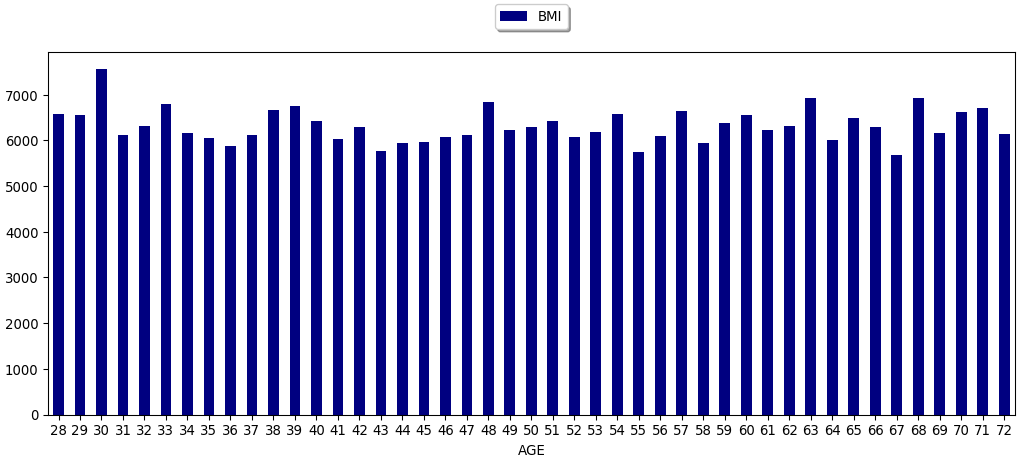

In [9]:
display(df_data)

## 4. Create an Apache® Spark machine learning model
In this section you will learn how to prepare data, create and train an Apache® Spark machine learning model.

### 4.1. Prepare data
In this subsection you will split your data into: train and  test  data sets.

In [10]:
split_data = df_data.randomSplit([0.8, 0.20], 24)
train_data = split_data[0]
test_data = split_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 8637
Number of testing records : 2163


As you can see our data has been successfully split into two data sets:
* The train data set, which is the largest group, is used for training.
* The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 4.2. Create pipeline and train a model
In this section you will create an Apache® Spark machine learning pipeline and then train the model.
In the first step you need to import the Apache® Spark machine learning packages that will be needed in the subsequent steps.

A sequence of data processing is called a _data pipeline_.  Each step in the pipeline processes the data and passes the result to the next step in the pipeline, this allows you to transform and fit your model with the raw input data.

In [11]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In the following step, convert all the string fields to numeric ones by using the StringIndexer transformer.

In [12]:
stringIndexer_label = StringIndexer(inputCol="HEARTFAILURE", outputCol="label").fit(df_data)
stringIndexer_sex = StringIndexer(inputCol="SEX", outputCol="SEX_IX")
stringIndexer_famhist = StringIndexer(inputCol="FAMILYHISTORY", outputCol="FAMILYHISTORY_IX")
stringIndexer_smoker = StringIndexer(inputCol="SMOKERLAST5YRS", outputCol="SMOKERLAST5YRS_IX")

Next, define estimators you want to use for classification. We will compare performance of Random Forest, Logistic Regression, and Naive Bayes in the following example.

In [13]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
lr = LogisticRegression()
nb = NaiveBayes(smoothing=1.0)

Finally, indexed labels back to original labels.

In [14]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=stringIndexer_label.labels)

In [15]:
vectorAssembler_features =  VectorAssembler(inputCols= ["AVGHEARTBEATSPERMIN","PALPITATIONSPERDAY", 
                                "CHOLESTEROL","BMI","AGE","SEX_IX","FAMILYHISTORY_IX",
                                "SMOKERLAST5YRS_IX","EXERCISEMINPERWEEK"], outputCol="features")
                                                      
transform_df_pipeline = Pipeline(stages=[stringIndexer_label, stringIndexer_sex, stringIndexer_famhist, stringIndexer_smoker, vectorAssembler_features])
transformed_df = transform_df_pipeline.fit(df_data).transform(df_data)
transformed_df.show()

+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+-----+------+----------------+-----------------+--------------------+
|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|CHOLESTEROL|BMI|HEARTFAILURE|AGE|SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|label|SEX_IX|FAMILYHISTORY_IX|SMOKERLAST5YRS_IX|            features|
+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+-----+------+----------------+-----------------+--------------------+
|                 93|                22|        163| 25|           N| 49|  F|            N|             N|               110|  0.0|   1.0|             0.0|              0.0|[93.0,22.0,163.0,...|
|                108|                22|        181| 24|           N| 32|  F|            N|             N|               192|  0.0|   1.0|             0.0|              0.0|[108.0,22.0,181.0...|
|                 86|    

Let's build our pipelines now. A pipeline consists of transformers and an estimator.

In [16]:
pipeline1 = Pipeline(stages=[stringIndexer_label, stringIndexer_sex, 
                             stringIndexer_famhist, stringIndexer_smoker,
                             vectorAssembler_features, rf, labelConverter])
m1Name = "Random Forest"

pipeline2 = Pipeline(stages=[stringIndexer_label, stringIndexer_sex,
                            stringIndexer_famhist, stringIndexer_smoker,
                            vectorAssembler_features, lr, labelConverter])
m2Name = "Logistic Regression"

pipeline3 = Pipeline(stages=[stringIndexer_label, stringIndexer_sex,
                             stringIndexer_famhist, stringIndexer_smoker,
                             vectorAssembler_features, nb, labelConverter])
m3Name = "Naive Bayes"

Now, you can train your Random Forest model by using the previously defined **pipelines** and **training data**.

In [19]:
model1 = pipeline1.fit(train_data)
model2 = pipeline2.fit(train_data)
model3 = pipeline3.fit(train_data)

Here, we write a function to extract the number of true and false positives and negatives from our dataframes.

In [20]:
from pyspark.sql.types import Row
import numpy as np
def getCMEntries(threshold):
    newThresholdDF = spark.sql("select label, p1, prediction as oldPrediction,"
    " case when p1 > " + str(threshold) + " then 1.0 else 0.0 end as newPrediction"
    " from inputToThreshold")
    newThresholdDF.registerTempTable("newThreshold")
    
    # Here is an SQL query to find true positives
    tpA = spark.sql("SELECT * FROM newThreshold WHERE label = 1 AND newprediction = 1")
    
    # Write an SQL query to find the number of false positives
    ### spark.sql("???")
    fpA = spark.sql("SELECT * FROM newThreshold WHERE label = 0 AND newprediction = 1")
    
    # Write an SQL query to find the number of false negatives
    ### spark.sql("???")
    fnA = spark.sql("SELECT * FROM newThreshold WHERE label = 1 AND newprediction = 0")
    
    # Write an SQL query to find the number of true negatives
    ### spark.sql("???")
    tnA = spark.sql("SELECT * FROM newThreshold WHERE label = 0 AND newprediction = 0")
    return (tpA.count(), fpA.count(), fnA.count(), tnA.count())

You can check your model accuracy now. To evaluate the model, use test data.

### 4.3. Compute Metrics as a Function of Threshold

It may be the case that the default threshold of 0.5 for classification is not ideal. Let's explore this possiblity, and use some standard metrics to evaluate model fitness.

$TP$,$FP$ are the number of true and false positives, $FP$,$TN$ are the number of false and true negatives.  $P$ and $N$ are the total number of ground truth positive and negatives. 

True Positive Rate:  $$TPR=TP/(FP + FN) = TP/P$$

False Positive Rate:  $$FP/N$$

Matthews Correlation Coefficient:
$$MCC = \frac{TP \cdot TN - FP\cdot FN}{[(TP+FP)\cdot(FP+FN)\cdot(FN+FP)\cdot(TN+FN)]^{1/2}}$$


The Area Under the Curve (AUC):
$$AUC=\int_{0}^{1}TPRd(FPR)$$

where the y axis is $TPR$ and the x axis is $FPR$.  A plot of $TPR$ versus $FPR$ is known as the Receiver Operating Characteristic (ROC).

Recall the trapezoid rule: 

$$\int_{x_0}^{x_N}f(x)dx=\sum_{i=0}^N(x_{i+1}-x_i)\cdot\frac{1}{2}\left [ (x_{i+1}) +f(x_i) \right ]$$

where $TPR=f(x)$ and $FPR=x$.

Use this formula to compute the AUC for the ROC, which is a plot of TPR (y axis) vs FPR (x axis).  The AUC is a measure of performance across all threshold values.

In [22]:
import numpy as np
numBins = 10
thresholds = np.array(range(0, numBins + 1))*1.0/numBins

Here, we are writing a function to compute $TPR$, $FPR$, etc. for each threshold setting (the default is 0.5).  In many cases, a slightly different threshold can perform better.  You are asked to fill in the blanks marked with "???".

In [23]:
def getModelThresholdStats(model_df, data):
    tp = np.array([i for i in range(0, numBins + 1 )])
    fp = np.array([i for i in range(0, numBins + 1 )])
    fn = np.array([i for i in range(0, numBins + 1 )])
    tn = np.array([i for i in range(0, numBins + 1 )])
    
    #generate dataframe to be used in thresholding:
    predictionsForROC = model_df.transform(data)
    predictionsForROC.registerTempTable("predictions")
    columnsForCM = spark.sql("select probability, prediction, label from predictions")
    extractedProbability = columnsForCM.rdd.map(lambda x: Row(p1 = np
    .asscalar(x[0][1]), prediction=x[1] , label=x[2])).toDF()
    extractedProbability.registerTempTable("inputToThreshold")
    
    # get the total number of positives and negatives in the predictions dataset:
    ### p = spark.sql("???").count()
    ### n = spark.sql("???").count()
    p = spark.sql("SELECT * from predictions WHERE label = 1").count()
    n = spark.sql("SELECT * from predictions WHERE label = 0").count()
                             
    # We know the number of true positives, etc. at the threshold edges:
    (tp[0],fp[0],fn[0],tn[0]) = (p, n, 0, 0)
    (tp[-1],fp[-1],fn[-1],tn[-1]) = (0, 0, p, n)
                             
    for (i, threshold) in zip(range(0, numBins + 1),thresholds):
        print(i, threshold)
        if (i>0 and i<numBins):
            (tp[i],fp[i],fn[i],tn[i]) = getCMEntries(threshold)
        print(tp[i],fp[i],fn[i],tn[i])
    
    # coercing to double precision from integers
    tp = tp*1.0; fp=fp*1.0; p=p*1.0; n=n*1.0
    
    # calculate the true positive and false positive rate
    ### tpr = ???
    ### fpr = ???
    tpr = tp/(tp + fn)
    fpr = fp/(tp + fn)
    
    # calculate Matthews Correlation Coefficient
    ### mcc = ???
    mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn) * (tn + fp) * (tn + fn))
    
    # calculate accuracy as a function of threshold
    accThreshold = (tp + tn) / (p + n)
    
    # calculate the area under the curve
    auc = - np.array(
             [(fpr[i + 1] - fpr[i]) * 0.5 * (tpr[i + 1] + tpr[i]) for i in range(0,numBins)]
            ).sum()
                             
    return (tpr, fpr, mcc, accThreshold, auc)

### Run your Parameter Sweeps...this should take ~1min.

In [25]:
print("getting stats for " + m1Name + ": train")
(tpr1,fpr1,mcc1,acc1,auc1) = getModelThresholdStats(model1, train_data)
print("getting stats for " + m1Name + ": test")
(tpr1Test,fpr1Test,mcc1Test,acc1Test,auc1Test) = getModelThresholdStats(model1, test_data)
print("getting stats for " + m2Name)
(tpr2,fpr2,mcc2,acc2,auc2) = getModelThresholdStats(model2, train_data)
print("getting stats for " + m2Name + ": test")
(tpr2Test,fpr2Test,mcc2Test,acc2Test,auc2Test) = getModelThresholdStats(model2, test_data)
print("getting stats for " + m3Name + ": train")
(tpr3,fpr3,mcc3,acc3,auc3) = getModelThresholdStats(model3, train_data)
print("getting stats for " + m3Name + ": test")
(tpr3Test,fpr3Test,mcc3Test,acc3Test,auc3Test) = getModelThresholdStats(model3, test_data)

getting stats for Random Forest: train
0 0.0
1427 7210 0 0
1 0.1
1109 2511 318 4699
2 0.2
893 854 534 6356
3 0.3
853 703 574 6507
4 0.4
571 240 856 6970
5 0.5
421 124 1006 7086
6 0.6
313 62 1114 7148
7 0.7
100 5 1327 7205
8 0.8
5 0 1422 7210
9 0.9
0 0 1427 7210
10 1.0
0 0 1427 7210
getting stats for Random Forest: test


/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in true_divide


0 0.0
361 1802 0 0
1 0.1
274 621 87 1181
2 0.2
232 197 129 1605
3 0.3
225 158 136 1644
4 0.4
154 59 207 1743
5 0.5
110 37 251 1765
6 0.6
75 17 286 1785
7 0.7
21 2 340 1800
8 0.8
4 0 357 1802
9 0.9
0 0 361 1802
10 1.0
0 0 361 1802
getting stats for Logistic Regression
0 0.0
1427 7210 0 0
1 0.1
1111 3023 316 4187
2 0.2
855 1060 572 6150
3 0.3
740 687 687 6523
4 0.4
595 429 832 6781
5 0.5
425 233 1002 6977
6 0.6
271 95 1156 7115
7 0.7
134 32 1293 7178
8 0.8
34 9 1393 7201
9 0.9
1 1 1426 7209
10 1.0
0 0 1427 7210
getting stats for Random Forest: test
0 0.0
361 1802 0 0
1 0.1
280 730 81 1072
2 0.2
226 247 135 1555
3 0.3
203 163 158 1639
4 0.4
161 109 200 1693
5 0.5
108 53 253 1749
6 0.6
67 26 294 1776
7 0.7
25 7 336 1795
8 0.8
8 1 353 1801
9 0.9
1 0 360 1802
10 1.0
0 0 361 1802
getting stats for Naive Bayes: train
0 0.0
1427 7210 0 0
1 0.1
876 3314 551 3896
2 0.2
841 3133 586 4077
3 0.3
809 2998 618 4212
4 0.4
785 2905 642 4305
5 0.5
770 2814 657 4396
6 0.6
742 2729 685 4481
7 0.7
715 2639 

Now plot your results...

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


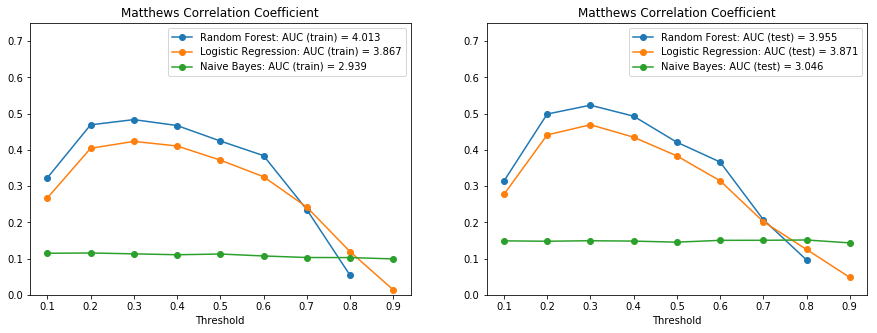

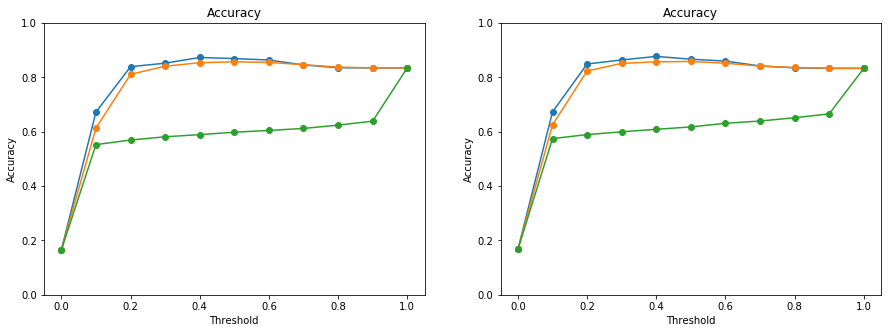

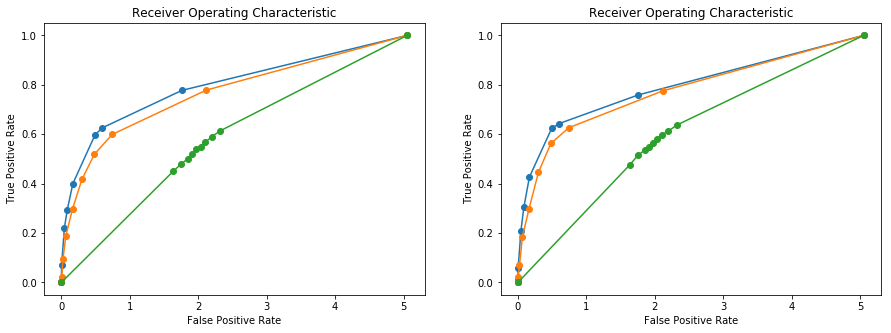

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(121)
plt.plot(thresholds, mcc1, '-o')
plt.plot(thresholds, mcc2, '-o')
plt.plot(thresholds, mcc3, '-o')
plt.title("Matthews Correlation Coefficient")
plt.xlabel("Threshold")
plt.ylim(0,0.75)
plt.legend([m1Name + ": AUC (train) = "+ str(round(auc1,3)),
m2Name + ": AUC (train) = "+ str(round(auc2,3)),
m3Name + ": AUC (train) = "+ str(round(auc3,3))])
plt.subplot(122)
plt.plot( thresholds, mcc1Test, '-o')
plt.plot( thresholds, mcc2Test, '-o')
plt.plot( thresholds, mcc3Test, '-o')
plt.title("Matthews Correlation Coefficient")
plt.xlabel("Threshold")
plt.ylim(0,0.75)
plt.legend([m1Name + ": AUC (test) = "+ str(round(auc1Test,3)),
m2Name + ": AUC (test) = "+ str(round(auc2Test,3)),
m3Name + ": AUC (test) = "+ str(round(auc3Test,3))])
plt.show()
plt.subplot(121)
plt.plot(thresholds, acc1,'-o')
plt.plot(thresholds, acc2,'-o')
plt.plot(thresholds, acc3,'-o')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Threshold")
plt.ylim(0,1.0)
plt.subplot(122)
plt.plot(thresholds, acc1Test,'-o')
plt.plot(thresholds, acc2Test,'-o')
plt.plot(thresholds, acc3Test,'-o')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Threshold")
plt.ylim(0,1.0)
plt.show()
plt.subplot(121)
plt.title("Receiver Operating Characteristic")
plt.plot(fpr1, tpr1,'-o')
plt.plot(fpr2, tpr2,'-o')
plt.plot(fpr3, tpr3,'-o')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.subplot(122)
plt.title("Receiver Operating Characteristic")
plt.plot(fpr1, tpr1Test,'-o')
plt.plot(fpr2, tpr2Test,'-o')
plt.plot(fpr3, tpr3Test,'-o')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

Based on the plots, which model do you think will best predict heart failure?  What is the optimal threshold setting?